# Scraping LADOT Volume Data from PDFs

## Background
At LADOT, we have a lot of historical (and relatively current) data on vehicle volume counts made at intersections throughout the city at various times. The problem is that the format the data are currently in - PDF - doesn't readily allow for the type of big data analyses that we would like to perform. So for this task I went about trying to develop a method for scraping these historical PDF counts and formatting them into usable data tables using any python package I could. I ended up settling on the pdfquery package, which is really just a lightweight wrapper around the much more well-known package PDFMiner.

The roughly 1,000 PDFs typically (though not always) look like this (converted to images for display here):

![Example Volume PDF](images/example.jpg?raw=TRUE)

##### Format Advantages
* One big advantage is that the (manual count) volume data sheets are generally in the same format.
* With very few exceptions, the PDFs were generated from another program (rather than being scanned images).

##### Format Challenges
There are a few minor challenges:
* There are multiple tables on each page, and each is formatted differently.
* The tables / text do not always appear in the exact same location on each page, which meant I needed a range of parameters to test for the bounding boxes.

## General Approach
My approach can be broken down into the few key parts: (1) define bounding boxes, (2) search for text within the bounding boxes (3) reformat the resulting text into multiple data tables, and (4) join the resulting tables to the ID established by the Bureau of Engineering. The details of the PDF extraction process is covered in the next python notebook.

##### Join Tables to BOE Count IDs
The last step involves taking all the data generated by this process and relating it to both a GPS coordinate and the intersection ID of the BOE centerline.

To do this exercise, I requested data from BOE that powers NavigateLA. There are actually two relevant tables that were provided by BOE. The first table, *dbo_dot_traffic_data_files* relates the name of the PDF to a TrafficID, so I can use this table to match the PDF names and get the resulting Traffic IDs. The second table, *dot_traffic_data* takes the TrafficID and relates it to the intersection ID (the same one that is usually on the front page of each traffic count summary) as well as the the lat / lon of the location and the intersection name. The structure of the two tables are shown below:

*dbo_dot_traffic_data_files*
* ID: Unique Identifier for the count
* TrafficID: This seems to be an identifier for the location
* TrafficType: Manual Count (manual_count) / Automatic Count (automatic_count) / Survey Data (survey_data)
* DocName: Name of the PDF document
* UniqueDocName: Not exactly sure the purpose of this one, perhaps at one time the DocNames were not unique?
* UploadDT: Date the PDF was uploaded to NavLA

*dot_traffic_data*
* TrafficID: Identifier for the location
* Intersection: The ID for the intersection, corresponding to the CL_NODE_ID in the BOE Centerline file
* ext: ?
* lat: Latitude
* lon: Longitude
* intersection: Intersection Name (eg ISLAND AVE at L ST)
* Shape: geometry object

In [18]:
### Setup
import csv
import glob
from datetime import datetime, date, time
import pandas as pd
import numpy as np
import folium
import os


### Getting Started
I'm actually going to start by loading and cleaning the tables provided by BOE (mentioned just above). I went ahead ane excluded any rows where the TrafficID was NaN (there was one value) since we would not be able to associate that to a valid intersection or location.

In [19]:
# Load traffic data files table
traffic_data_files_path = 'data/TrafficCountFileStructure/boe_tables/dbo_dot_traffic_data_files.csv'
dbo_dot_traffic_data_files = pd.read_csv(traffic_data_files_path, parse_dates=['UploadDT'], encoding="ISO-8859-1")

# Drop rows where TrafficID is NaN, convert TrafficID to int type
dbo_dot_traffic_data_files = dbo_dot_traffic_data_files.dropna(axis=0, how='any',subset=['TrafficID'])
dbo_dot_traffic_data_files['TrafficID'] = dbo_dot_traffic_data_files['TrafficID'].astype(int)

# Subset out Survey Data and Automatic Counts
dbo_dot_traffic_data_files = dbo_dot_traffic_data_files[(dbo_dot_traffic_data_files['TrafficType'] == 'manual_count')]

# See traffic data files head
print("There are " + str(len(dbo_dot_traffic_data_files)) + " records in the table.")
dbo_dot_traffic_data_files.head()

There are 9034 records in the table.


,ID,TrafficID,TrafficType,DocName,UniqueDocName,UploadDT
0,1,1435,manual_count,2_GRAVDM93.pdf,2_GRAVDM93.pdf,2007-04-02 08:38:30
1,2,1436,manual_count,4_CULVIS95.pdf,4_CULVIS95.pdf,2008-02-20 09:15:12
2,3,1436,manual_count,4_MONCUL100928.pdf,4_MONCUL100928.pdf,2011-08-09 13:58:55
3,4,1437,manual_count,16_VISTA DEL MAR.WATERVIEW07.pdf,16_VISTA DEL MAR.WATERVIEW07.pdf,2007-11-28 13:01:46
4,5,1437,manual_count,16_visvis01.pdf,16_visvis01.pdf,2007-12-03 16:30:42


##### Step 1: Make sure I have all the Volume Data PDFs (prep) and Related TraffcIDs
I knew we needed to be able to join all of the data we pull out of the PDF to the table provided by BOE. Since the BOE Table *dbo_dot_traffic_data_files* contains a field with the filename, this is an easy join with our filename. Once this join is complete we will have the TrafficID.

My initial process for doing this involved just looping through *dbo_dot_traffic_data_files* (after subsetting for the manual counts as I did above), and then just grabbing a file with the same filename in my folder, but then I realized that there were many rows that did not have a PDF in the folder. By doing the join, I could easily identify which PDFs were missing.

I went a bit further - to get a graphical sense of the differences, I went ahead and created a venn diagram showing the results of the join from the BOE table and my folder of manual PDF counts. As you can tell, there is quite a difference.

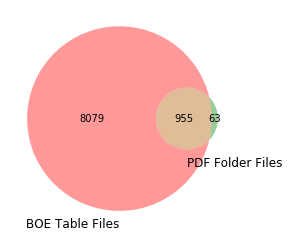

In [20]:
# Get Venn Diagram package
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles

# Grab all PDFs within the folder
files = glob.glob('data\TrafficCountData\Manual\Original\*.pdf')
file_names = [os.path.basename(file) for file in files]

# Create df from filenames / paths
pdf_df = pd.DataFrame(
    {'path':files,
     'filename':file_names
    })

# Join pdf_df to BOE tables
traffic_data_files_leftjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='left', left_on='DocName', right_on='filename')
traffic_data_files_innerjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='inner', left_on='DocName', right_on='filename')
traffic_data_files_rightjoin = dbo_dot_traffic_data_files.merge(pdf_df, how='right', left_on='DocName', right_on='filename')

### Create Venn Diagram showing differences

# Subset sizes
s = (
    (len(traffic_data_files_leftjoin) - len(traffic_data_files_innerjoin)),  # BOE Table only count
    (len(traffic_data_files_rightjoin)-len(traffic_data_files_innerjoin)),  # PDF Folder only count
    len(traffic_data_files_innerjoin),  # Joined Files count
)

# Subset labels
v = venn2(subsets=s, set_labels=('BOE Table Files', 'PDF Folder Files'))

# Show the plot
plt.show()

As the Venn Diagram makes obvious, there is quite a difference. Of the 1,018 PDF files I started with, I was able to match 955 (~94%) of them to a row in the BOE table. Roughly 6% of the files (63) were unable to be matched in the BOE table.

However, it looks like the folder of Manual PDF counts that I was initially pulling from contained only about 10% (1018 of the 9034 total) of the manual count files in BOE's NavigateLA system. We don't have to give up here. Since NavigateLA hosts the PDFs online (and they are public), we can go ahead and download them from the NavigateLA website to fill out our set of Manual Count PDFs. We will do this by (1) looping through all the names in the BOE table that do not have a match and (2) using the python urllib library to pull the PDFs to a new folder.


##### Step 2: Download the PDF documents (prep)
This script loops through my table of document names and downloads the PDFs from the web. 

In [21]:
import urllib
import time
from pathlib2 import Path

# Location to where I will be downloading the files
folder = "data/TrafficCountData/Manual/All/"

# Base URL 
base_url = "http://boemaps.eng.ci.la.ca.us/dot/traffic_data/manual_counts/"

# Get the filenames from the BOE table that don't yet have a matching PDF
traffic_data_files_missing = traffic_data_files_leftjoin[(~traffic_data_files_leftjoin.DocName.isin(traffic_data_files_innerjoin.DocName))&(~traffic_data_files_leftjoin.filename.isin(traffic_data_files_innerjoin.filename))]

# Loop through resulting rows
for index, row in traffic_data_files_missing.iterrows():
    
    # Filename, URL, Location
    filename = row['DocName']
    url = base_url + filename
    download_location = folder + filename
    
    # If it is already in the folder from first round of NavLA downloads, skip
    if Path(download_location).is_file():
        pass
    
    # Otherwise, try to download
    else:
        
        try:
            # Download to folder
            urllib.request.urlretrieve(url, download_location)

            # To Not overwhelm the server
            time.sleep(.2)
        
        except:
            raise
            #pass

print("Finished downloading files.")


Finished downloading files.


##### [Update 1/7/18] Step 3: Scrape NavLA for missing document names
One of the issues I realized only later was that the initial table of documents provided by BOE for the volume count data was incomplete, and there were more documents hosted on Navigate LA than revealed in that table. I wanted to fill out the difference. The first thing I did to get a more comprehensive listing of the documents on Navigate LA was run a small web crawler to loop through Traffic IDs (generated by BOE) and grab fileneames from each one.

The script below scrapes the NavLA site, scraping the following pieces of information:

* intersection: The name of the intersection / location
* node_id: The Bureau of Engineering CL_NODE_ID that corresponds to that location
* automatic: A list of filenames for automatic count PDF documents 
* manual: A list of filenames for manual count PDF documents

For someone without the benefit of the BOE tables given ahead of time, that person could start at this step and continue to replicate the rest of the work. The only piece of this query that needs to be updated is the max value for the Traffic ID, which I found by just manually incrementing up from around 9,000 to max here, which is 9,434 (that number will probably continue to increase as time goes on) The final result is a json dump, which will will then import later and use for joining to the BOE intersection and centerline file later.

In [ ]:
### Scrape NavLA for All Count Document Names
### and save to JSON .txt file
from lxml import html, etree
import requests
import time
import json
import urllib

Count_data = []

# Base URL to use for the web scraping
base_url = "http://boemaps.eng.ci.la.ca.us/reports/dot_traffic_data_report.cfm?trafficid="

parser = etree.HTMLParser(remove_blank_text=True,encoding='utf-8')

# Loop through integers, grab all data in range
for traffic_id in range(1,9434):
    
    # Metering the requests
    time.sleep(.1)
    
    # The dictionary to hold the final data
    d = {}
    
    # Make the request
    url = base_url + str(traffic_id)
    page = requests.get(url)
    tree = etree.HTML(page.content)
    result = etree.tostring(tree,method='html')
    
    # Parse the data
    table_info = tree.xpath('//td[@class="tablerecord"]/text()')
    if len(table_info) > 0:

        # Parse the Node ID
        node_id = tree.xpath('//td[@class="tablerecord"]/text()')[0]
        node_id = node_id.replace(u'\xa0', u'')

        # Parse the Intersection Name
        intersection = tree.xpath('//td[@class="tablerecord"]/text()')[1]
        intersection = intersection.replace(u'\r\n\t\t\t\t\r\n\t\t\t\t\t', u'')
        intersection = intersection.replace(u'\xa0\r\n\t\t\t\t\r\n\t\t\t',u'')

        ##### Automatic Counts
        # Select the table that contains the automatic counts
        automatic_count_table = tree.xpath('//b[text()="Automatic Count"]/../../..')
        
        # If there is at least automatic count PDF, grab filenames
        if len(automatic_count_table) > 0:
            automatic1 = etree.tostring(automatic_count_table[0])
            automatic_count_table = etree.XML(automatic1, parser=parser)
            automatic_count_pdfs = automatic_count_table.xpath('//a/text()')
            d['automatic'] = automatic_count_pdfs
        else:
            d['automatic'] = []

        ##### Manual Counts
        # Select the table that contains manual counts
        manual_count_table = tree.xpath('//b[text()="Manual Count"]/../../..')

        # If there is at least manual count PDF, grab filenames
        if len(manual_count_table) > 0:
            manual1 = etree.tostring(manual_count_table[0])
            manual_count_table = etree.XML(manual1, parser=parser)
            manual_count_pdfs = manual_count_table.xpath('//a/text()')
            d['manual'] = manual_count_pdfs
        else:
            d['manual'] = []

        d['node_id'] = node_id
        d['traffic_id'] = traffic_id
        d['intersection'] = intersection
        Count_data.append(d)

with open('data/TrafficCountFileStructure/navLAdump.txt', 'w') as outfile:
    json.dump(Count_data, outfile)

print("Complete.")


##### [Update 1/7/18] Step 4: Complete the Library of Manual Count PDFs
For this exercise, I wanted to collect the rest of the PDF files from the internet. I'll start by looking at the documents that I was able to pull from the web scrape exercise, join it with a table listing everything I have, and get the difference. From there, I can query NavigateLA by the PDF name and pull it down to my list of flies.

Now that we have the data pulled from Navigate LA stored in navLAdump.txt, let's load it. I'll make some slight modificatons to the json data structure before we can bring it into a pandas data frame and join to the rest of the data.

In [22]:
### Convert the JSON .txt file into a pandas dataframe for analysis
import json
import pandas as pd

# Lcoation of the json file
traffic_count_file = 'data/TrafficCountFileStructure/navLAdump.txt'

# Load json
with open(traffic_count_file) as f:
    traffic_count_files = json.load(f)

# New list data structure
count_files = []
count_files_labels = ['cl_node_id','location','traffic_id','type','file']

for location in traffic_count_files:
    
    # New list for each count, add intersection infomration & node id
    count = []
    node_id = location['node_id']
    loc = location['intersection']
    traffic_id = location['traffic_id']
    
    # Add a row for each manual count
    if len(location['manual']) > 0:
        for man in location['manual']:
            man2 = man + '.PDF'
            count = [node_id, loc, traffic_id, 'manual', man2]
            count_files.append(count)
    
    # Add a row for each automatic count
    if len(location['automatic']) > 0:
        for auto in location['automatic']:
            auto2 = auto + '.PDF'
            count = [node_id, loc, traffic_id, 'automatic', auto2]
            count_files.append(count)

# Create the new dataframe
count_files_df = pd.DataFrame.from_records(count_files, columns=count_files_labels)
count_files_df.insert(0,'count_id',range(1,1+len(count_files_df)))

print("There are " + str(len(count_files_df)) + " files on NavigateLA. Of these, " + str(len(count_files_df[(count_files_df['type'] == 'manual')])) + ' files are manual counts.')
count_files_df.head()

# Write out the csv to a file
count_files_df.to_csv(path_or_buf='data/TrafficCountFileStructure/navLAfiles.csv',
                      index=False,
                      sep=',')

There are 26840 files on NavigateLA. Of these, 9460 files are manual counts.


Now that I have this updated list of files from Navigate LA, I can get the difference between this list and what I have downloaded already (located in data/TrafficCountData/Manual/All/). 

In [28]:
### Inventory PDFs & Get difference with NavLA scrape
# Grab all PDFs within the folder
files = glob.glob('data/TrafficCountData/Manual/All/*.pdf')
file_names = [os.path.basename(file) for file in files]

# Create df from filenames / paths
pdf_df = pd.DataFrame(
    {'path':files,
     'filename':file_names
    })

# Uppercase the filenames for the join in the next step
pdf_df['filename'] = pdf_df['filename'].str.upper()

print("There are " + str(len(pdf_df)) + " files in the Manual Count folder.")
pdf_df.head()

There are 9522 files in the Manual Count folder.


,filename,path
0,00000001.PDF,data/TrafficCountData/Manual/All\00000001.pdf
1,1-2-3-CALRIV01.PDF,data/TrafficCountData/Manual/All\1-2-3-calriv0...
2,10018_GRA27S94.PDF,data/TrafficCountData/Manual/All\10018_GRA27S9...
3,10041_GRA35S02.PDF,data/TrafficCountData/Manual/All\10041_gra35s0...
4,1009_GAGGRA02.PDF,data/TrafficCountData/Manual/All\1009_gaggra02...


In [29]:
### Prepare to download remaining PDF Files from NavLA
import urllib
import time
from pathlib2 import Path

### Join list of PDFs to Count Files Manual Counts
count_files_manual = count_files_df[(count_files_df['type'] == 'manual')]
count_files_leftjoin = count_files_manual.merge(pdf_df, how='left', left_on='file', right_on='filename')
count_files_innerjoin = count_files_manual.merge(pdf_df, how='inner', left_on='file', right_on='filename')

# Location to where I will be downloading the files
folder = "data/TrafficCountData/Manual/All/"

# Base URL 
base_url = "http://boemaps.eng.ci.la.ca.us/dot/traffic_data/manual_counts/"

# Get the filenames from the BOE table that don't yet have a matching PDF
count_files_missing = count_files_leftjoin[(~count_files_leftjoin.file.isin(count_files_innerjoin.file))&(~count_files_leftjoin.filename.isin(count_files_innerjoin.filename))]
print('There are ' + str(len(count_files_missing)) + ' files that are missing and need to be downloaded.')
count_files_missing.head()

There are 3 files that are missing and need to be downloaded.


,count_id,cl_node_id,location,traffic_id,type,file,filename,path
25,47,4279,95TH ST at HOOVER ST,17,manual,4279_Â­Â­HOO95S.PDF,NaN,NaN
1801,3207,8622,HOOVER ST at PICO BLVD,812,manual,8622_Â­HOOPIC93.PDF,NaN,NaN
2033,3643,8930,HOOVER ST AT VENICE BLVD,889,manual,8930_Â­HOOVEN99.PDF,NaN,NaN


In [30]:
### Download Remaining Manual Count PDFs
# Loop through resulting rows
for index, row in count_files_missing.iterrows():
    
    # Filename, URL, Location
    filename = row['file']
    
    # Encode string into ASCII set for url
    #filename = urllib.parse.quote(filename)
    url = base_url + urllib.parse.quote(filename)
    download_location = folder + filename
    
    # If it is already in the folder from first round of NavLA downloads, skip
    if Path(download_location).is_file():
        pass
    
    # Otherwise, try to download
    else:
        
        print('downloading ' + str(filename))
        
        try:
            # Download to folder
            urllib.request.urlretrieve(url, download_location)

            # To Not overwhelm the server
            time.sleep(1)
        
        except:
            print('   failed to download' + str(filename))
            pass

print("Finished downloading from NavigateLA")

downloading 4279_Â­Â­HOO95S.PDF
   failed to download4279_Â­Â­HOO95S.PDF
downloading 8622_Â­HOOPIC93.PDF
   failed to download8622_Â­HOOPIC93.PDF
downloading 8930_Â­HOOVEN99.PDF
   failed to download8930_Â­HOOVEN99.PDF
Finished downloading from NavigateLA
